In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from eidynamics import plot_tools
%matplotlib widget

In [5]:
rawdatapath = Path(r"C:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Surprise\all_cells_surprise_CC_long.h5")
rawdatadf = pd.read_hdf(rawdatapath, key='data')

In [3]:
data_list = []
tracelets = []
patternlist = 'PAAAAAAAABBBBBBBBCCCCCCCCDDDDDDDD'
pt20hz = rawdatadf[(rawdatadf['exptID']==4)&(rawdatadf['cellID']==3101)&(rawdatadf['sweep']==2)]['pulseTimes'].to_numpy()[0]
print(rawdatadf.shape)
for i in range(rawdatadf.shape[0]):
    row = rawdatadf.iloc[i,:]
    trace = row[59:100059]
    # baseline subtract
    trace = trace - np.mean(trace[:2000])
    cell = row['cellID']
    expt = row['exptID']
    freq = row['stimFreq']
    if cell == 2821 or cell == 2822:
        if expt in [14,13,11,10,8,30,34,37]:
            continue
        else:
            scaling_factor = 0.05*0.05
    else:
        scaling_factor = 1
    IPI = 20000/freq
    numSq = row['numSq']
    pulse_times = row['pulseTimes']
    if len(pulse_times) != 33:
        print(f'Cell {cell}, expt {expt}, sweep {row["sweep"]}  has {len(pulse_times)} pulses')
        pulse_times = pt20hz
    for i,pt in enumerate(pulse_times):
        # print(pt, pt+IPI)
        tracelet = trace[pt:pt+IPI]
        peak_point = np.argmax(tracelet)
        tracelet_min = np.min(tracelet[:peak_point])
        response = scaling_factor * ( np.max(tracelet) - tracelet_min ) # subtraction of min value gives baseline subtracted response
        pattern = patternlist[i]
        data_list.append({
            'cell': cell,
            'expt': expt,
            'repeat': row['sweep'],
            'freq': freq,
            'numSq': numSq,
            'pulseidx': i,
            'pattern': pattern,
            'response': response
        })
datadf = pd.DataFrame(data_list)

datadf['pulse'] = datadf.groupby(['cell', 'expt', 'repeat', 'pattern']).cumcount()
datadf['transition'] = datadf['pattern'].shift(-1) != datadf['pattern']
datadf['transition'] = datadf['transition'].astype(int)
datadf.loc[datadf['pattern']=='P', 'transition'] = 0
datadf.loc[(datadf['pulse'].isin([6,7])) & (datadf['pattern']!='D'), 'condition'] = 'pre'
datadf.loc[(datadf['pulse'].isin([0,1])) & (datadf['pattern']!='A') & (datadf['pattern']!='P'), 'condition'] = 'post'
datadf['transition_count'] = datadf.groupby(['cell', 'expt', 'repeat'])['transition'].cumsum().shift(-1)

# save datadf
datapath = Path(r"C:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Surprise\all_cells_surprise_responses.h5")
datadf.to_hdf(datapath, key='data', mode='w')

(350, 400059)
Cell 3101, expt 4, sweep 1  has 9 pulses


C:\Users\Aditya\AppData\Local\Temp\ipykernel_27768\966863853.py:56: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['pattern', 'condition'], dtype='object')]

  datadf.to_hdf(datapath, key='data', mode='w')


In [4]:
# convert datadf to wideform
datadf2 = datadf.pivot_table(index=['cell', 'expt', 'numSq', 'freq','pattern','repeat'], columns='pulse', values='response').reset_index()
# save datadf2
datapath = Path(r"C:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Surprise\all_cells_surprise_responses_wide.h5")
datadf2.to_hdf(datapath, key='data', mode='w')

C:\Users\Aditya\AppData\Local\Temp\ipykernel_27768\1866687516.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  datadf2.to_hdf(datapath, key='data', mode='w')
C:\Users\Aditya\AppData\Local\Temp\ipykernel_27768\1866687516.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->block0_items] [items->None]

  datadf2.to_hdf(datapath, key='data', mode='w')


In [5]:
datadf_filt = datadf[datadf['condition'].notnull()].pivot_table(index=['cell', 'expt', 'numSq','freq','repeat','transition_count', ], columns='pulse', values='response').reset_index()
datadf_filt.rename(columns={6:-1, 7:-2}, inplace=True)
# convert back to long form
datadf_filt_long = datadf_filt.melt(id_vars=['cell', 'expt', 'numSq','freq', 'repeat','transition_count'], value_name='response')
datadf_filt_long.loc[(datadf_filt_long['pulse']<0), 'condition'] = 'pre'
datadf_filt_long.loc[(datadf_filt_long['pulse']>=0), 'condition'] = 'post'
# save
datapath = Path(r"C:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Surprise\all_cells_surprise_responses_only_transitions.h5")
datadf_filt_long.to_hdf(datapath, key='data', mode='w')


C:\Users\Aditya\AppData\Local\Temp\ipykernel_27768\3430642424.py:9: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block4_values] [items->Index(['pulse', 'condition'], dtype='object')]

  datadf_filt_long.to_hdf(datapath, key='data', mode='w')


In [9]:
datadf_filt_wide = datadf_filt_long.pivot_table(index=['cell', 'expt', 'numSq', 'freq', 'repeat','transition_count'], columns='pulse', values='response').reset_index()
datadf_filt_wide['transition_response'] =  2* (datadf_filt_wide[0]+datadf_filt_wide[1]-( datadf_filt_wide[-1]+datadf_filt_wide[-2])) / (datadf_filt_wide[0]+datadf_filt_wide[1]+ datadf_filt_wide[-1]+datadf_filt_wide[-2])
datadf_filt_wide['pre'] =  0.5*( datadf_filt_wide[-1]+ datadf_filt_wide[-2])
datadf_filt_wide['post'] = 0.5*( datadf_filt_wide[0] + datadf_filt_wide[1] )
datadf_filt_wide['transition_count'] = datadf_filt_wide['transition_count'].astype('int')
datadf_filt_wide['cell'] = datadf_filt_wide['cell'].astype('int')

# save
datapath = Path(r"C:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Surprise\all_cells_surprise_responses_transition_wide.h5")
datadf_filt_wide.to_hdf(datapath, key='data', mode='w')

C:\Users\Aditya\AppData\Local\Temp\ipykernel_27768\3699336834.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  datadf_filt_wide.to_hdf(datapath, key='data', mode='w')
C:\Users\Aditya\AppData\Local\Temp\ipykernel_27768\3699336834.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  datadf_filt_wide.to_hdf(datapath, key='data', mode='w')


# Load data

In [6]:
datapath = Path(r"C:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Surprise\all_cells_surprise_responses.h5")
datadf = pd.read_hdf(datapath, key='data')

datapath = Path(r"C:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Surprise\all_cells_surprise_responses_wide.h5")
datadf2 = pd.read_hdf(datapath, key='data')

datapath = Path(r"C:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Surprise\all_cells_surprise_responses_only_transitions.h5")
datadf_filt_long = pd.read_hdf(datapath, key='data')

datapath = Path(r"C:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Surprise\all_cells_surprise_responses_transition_wide.h5")
datadf_filt_wide = pd.read_hdf(datapath, key='data')

In [5]:
datadf.head(5)

cell  expt  repeat  freq  numSq  pulseidx pattern  response  pulse  \
0  4041     9       1    20     20         0       P  2.755959      0   
1  4041     9       1    20     20         1       A  5.635654      0   
2  4041     9       1    20     20         2       A  8.874990      1   
3  4041     9       1    20     20         3       A  5.884237      2   
4  4041     9       1    20     20         4       A  2.285205      3   

   transition condition  transition_count  
0           0       NaN               0.0  
1           0       NaN               0.0  
2           0       NaN               0.0  
3           0       NaN               0.0  
4           0       NaN               0.0

In [6]:
datadf2.head(5)

pulse  cell  expt  numSq  freq pattern  repeat         0         1         2  \
0      2681     1     15     8       A       1  2.535950  4.311079  3.787385   
1      2681     1     15     8       A       2  5.307123  5.536522  7.121663   
2      2681     1     15     8       A       3  3.720579  4.162971  4.080958   
3      2681     1     15     8       A       4  5.097745  6.036057  4.205705   
4      2681     1     15     8       A       5  5.982338  7.378988  4.461929   

pulse         3         4         5         6         7  
0      3.562783  3.182352  4.058556  3.389258  6.067845  
1      3.546396  3.012722  6.272867  3.573202  3.907132  
2      6.633678  7.279483  4.483070  6.206914  5.869318  
3      3.436298  7.073277  6.365393  3.058065  5.588402  
4      2.432702  5.365591  4.297655  5.509453  4.314108

In [7]:
sample = datadf_filt_long[datadf_filt_long['response'].notnull()]
sample[(sample['cell']==2681) & (sample['expt']==1) & (sample['repeat']==1)&(sample['transition_count']==1)]

cell  expt  numSq  freq  repeat  transition_count pulse  response  \
0     2681     1     15     8       1               1.0     0  5.155824   
810   2681     1     15     8       1               1.0     1  5.645387   
1620  2681     1     15     8       1               1.0    -1  3.389258   
2430  2681     1     15     8       1               1.0    -2  6.067845   

     condition  
0         post  
810       post  
1620       pre  
2430       pre

## Plots

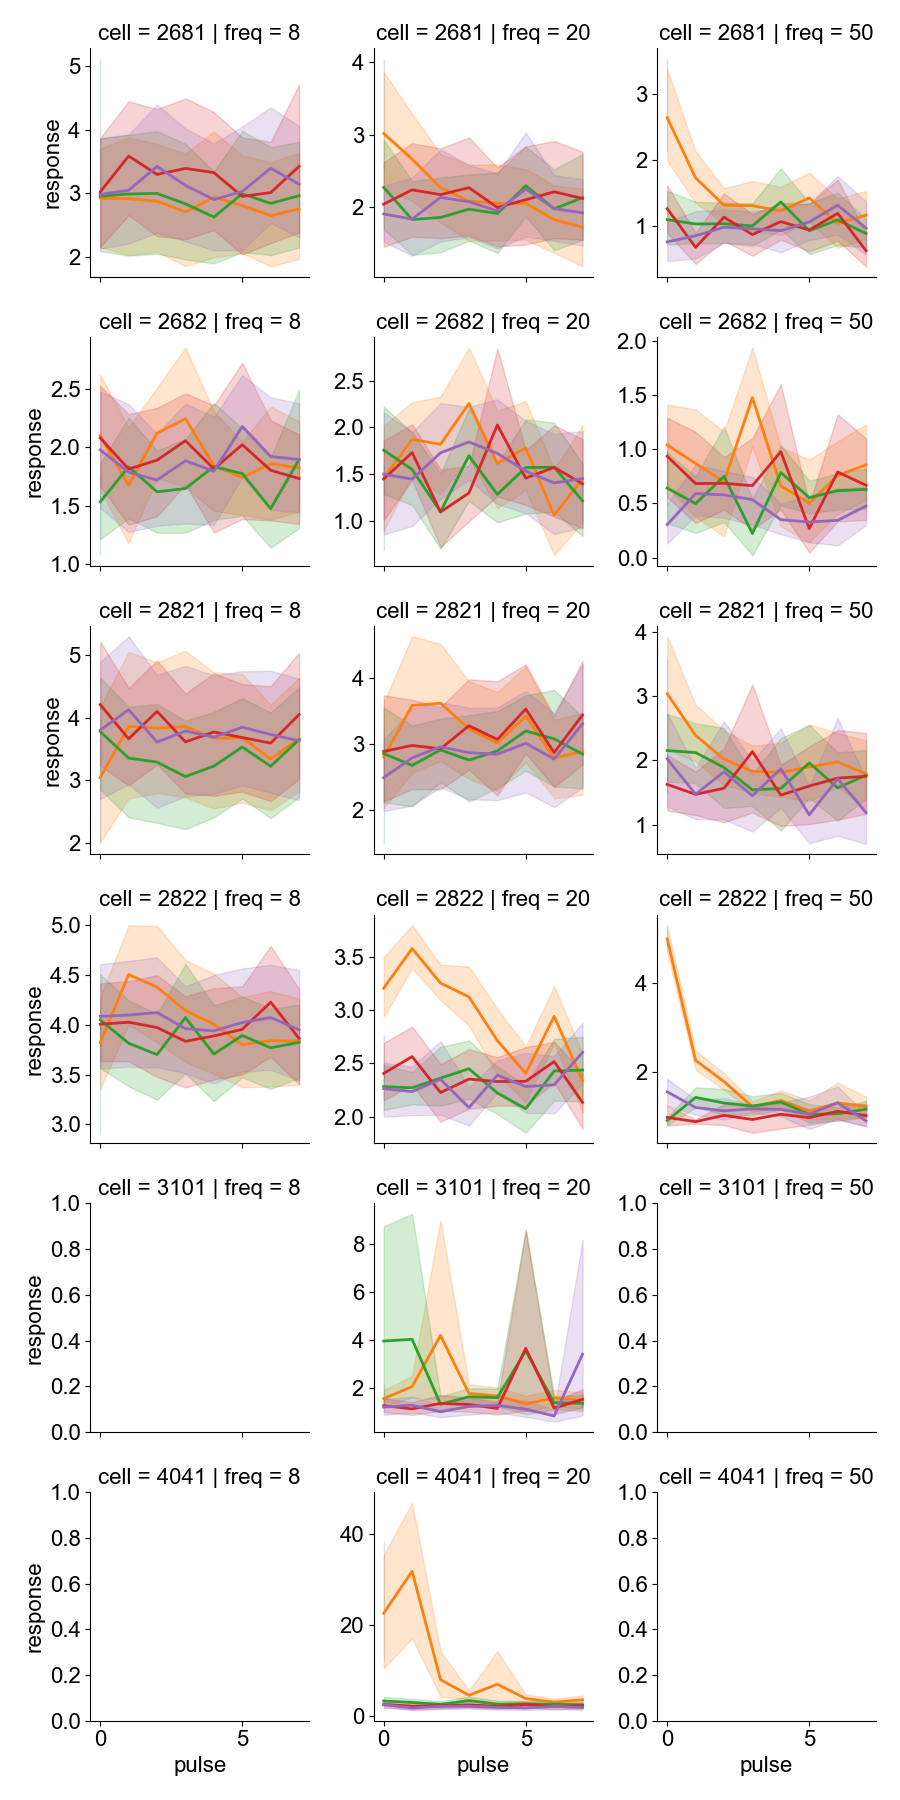

In [10]:
# for all cells, for each frequencies, visualize the transitions
# facetgrid
fg = sns.FacetGrid(datadf, col='freq', row='cell', hue='pattern', sharex=True, sharey=False)
fg.map(sns.lineplot, 'pulse', 'response')

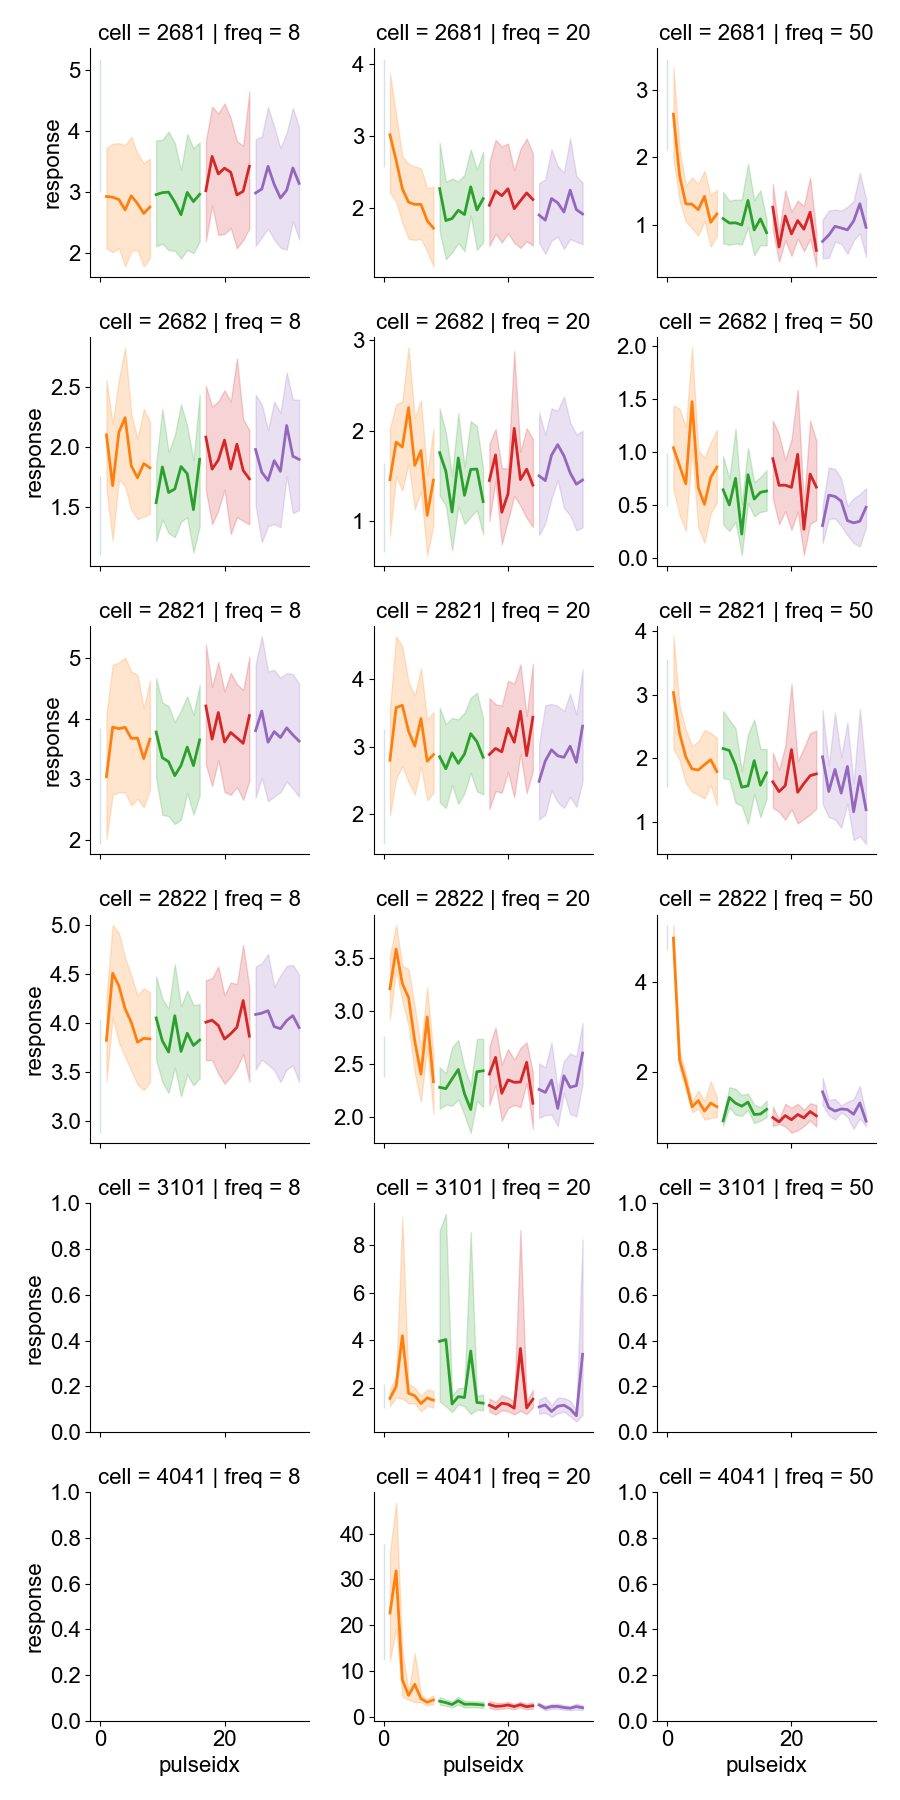

In [11]:
# for all cells, for each frequencies, visualize the transitions
# facetgrid
fg2 = sns.FacetGrid(datadf, col='freq', row='cell', hue='pattern', sharex=True, sharey=False)
fg2.map(sns.lineplot, 'pulseidx', 'response')

C:\Users\Aditya\AppData\Local\Temp\ipykernel_35496\1220716007.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['response'] = sample['response'] - sample.groupby(['cell', 'expt', 'freq', 'repeat', 'transition_count'])['response'].transform('mean')


Text(2.5, 0.45, 'post')

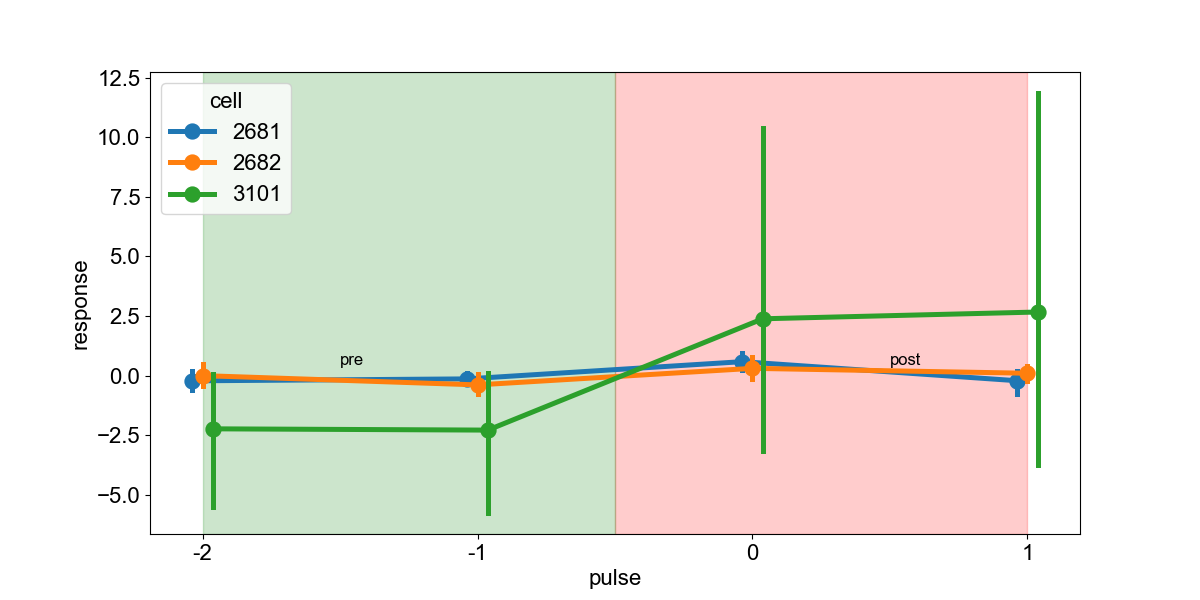

In [125]:
# plot the pulse vs responses for each cell
plt.figure(figsize=(12, 6))
sample = datadf_filt_long[(datadf_filt_long['freq']==20)&(datadf_filt_long['numSq']==15)&(datadf_filt_long['transition_count']==1)&(datadf_filt_long['cell'].isin([3101,2681,2682,2822]))]
# subtract the mean of two pre and two post values from all pre and post values
sample['response'] = sample['response'] - sample.groupby(['cell', 'expt', 'freq', 'repeat', 'transition_count'])['response'].transform('mean')
sample.head(10)
sns.pointplot(x='pulse', y='response', hue='cell', data=sample, palette='tab10', dodge=True)
plt.axvspan(1.5,3, color='red', alpha=0.2)
plt.axvspan(0, 1.5, color='green', alpha=0.2)
plt.text(0.5, 0.45, 'pre', fontsize=12, color='k')
plt.text(2.5, 0.45, 'post', fontsize=12, color='k')

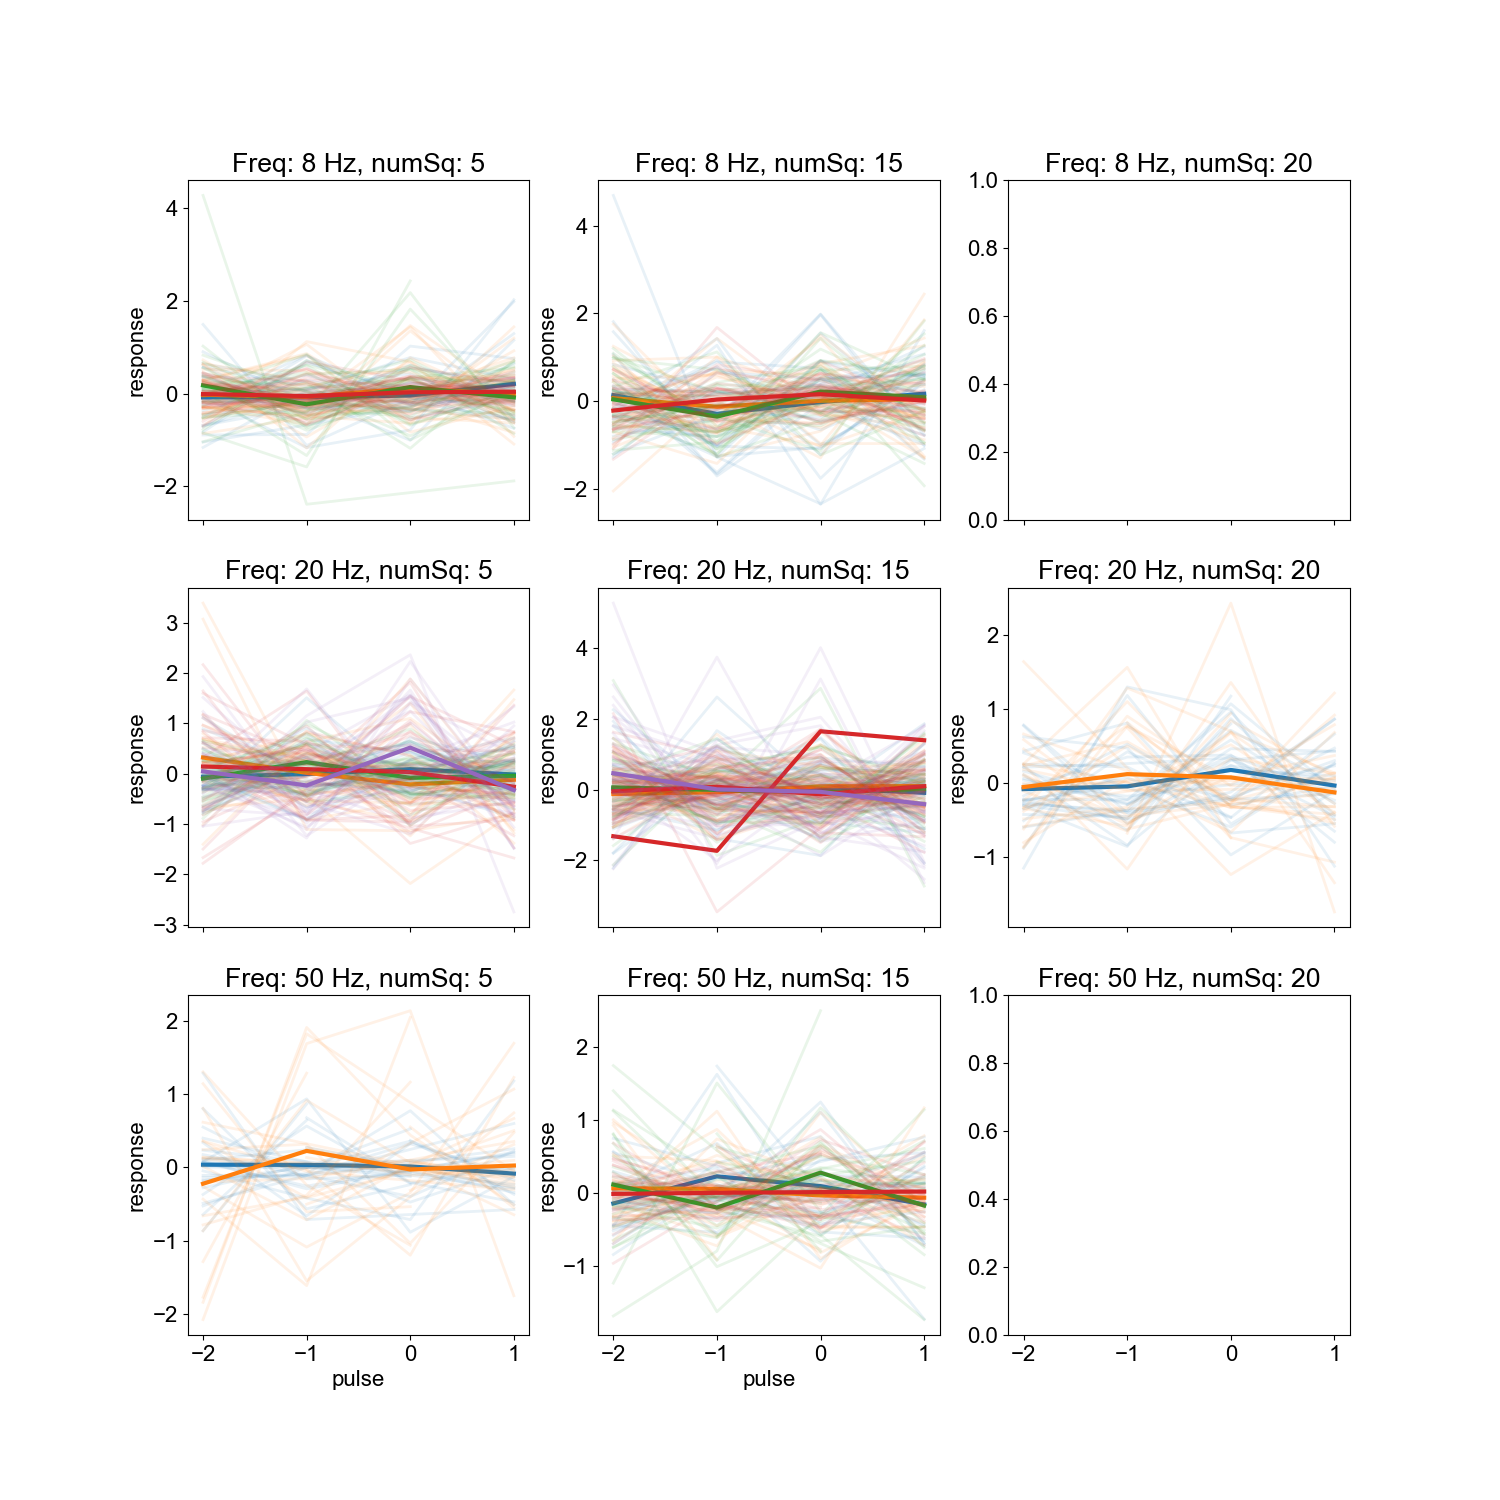

In [127]:
# make facetgrid of datadf_filt_long across numsq and freq
fig, ax = plt.subplots(3,3, sharex=True, sharey=False, figsize=(15,15))
numcolours = datadf_filt_long['cell'].nunique()
datadf_filt_long['pulse'] = datadf_filt_long['pulse'].astype(int)
cell_colors = sns.color_palette('tab10', numcolours)
for j,f in enumerate([8,20,50]):
    for k,n in enumerate([5,15,20]):
        ax[j,k].set_title(f"Freq: {f} Hz, numSq: {n}")
        # ax[j,k].set_ylim([0,])
        sample = datadf_filt_long[ (datadf_filt_long['numSq']==n) &(datadf_filt_long['freq']==f) ]
        cells = sample['cell'].unique()
        for i,c in enumerate(cells):
            cell_sample = sample[sample['cell']==c]
            for ex in cell_sample['expt'].unique():
                cell_ex_sample = cell_sample[cell_sample['expt']==ex]
                # print(f,n,c,ex, cell_ex_sample.shape)
                for r in cell_ex_sample['repeat'].unique():
                    for t in [1,2,3]:
                        transition_sample = cell_ex_sample[(cell_ex_sample['repeat']==r)&(cell_ex_sample['transition_count']==t)]
                        if transition_sample['response'].max() > 20:
                            continue
                        assert transition_sample.shape[0] == 4
                        offset = transition_sample['response'].mean()
                        transition_sample.loc[:,'response'] -= offset
                        sns.lineplot(data=transition_sample, x='pulse', y='response', ax=ax[j,k], color=cell_colors[i], lw=2, alpha=0.1)
                # take a mean across all the repeats for the cell_ex_sample dataframe
                cell_ex_mean = cell_ex_sample.select_dtypes(include=['number']).groupby('pulse').mean().reset_index()
                assert cell_ex_mean.shape[0] == 4
                offset = cell_ex_mean['response'].mean()
                cell_ex_mean.loc[:,'response'] -= offset
                sns.lineplot(data=cell_ex_mean, x='pulse', y='response', ax=ax[j,k], color=cell_colors[i], lw=3, alpha=1)


(-2.0, 2.0)

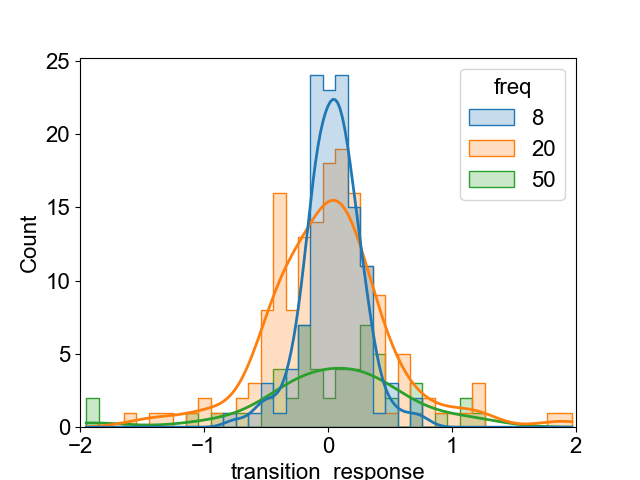

In [12]:
# for c in datadf_filt_wide['cell'].unique():
# a grid of histograms of post/pre ratio for each frequency and numSq
fig,ax = plt.subplots(1,1)
sns.histplot(data=datadf_filt_wide[(datadf_filt_wide['numSq']==15)], x='transition_response', hue='freq', binwidth=0.1, palette='tab10',kde=True, element='step', ax=ax)
ax.set_xlim(-2,2)

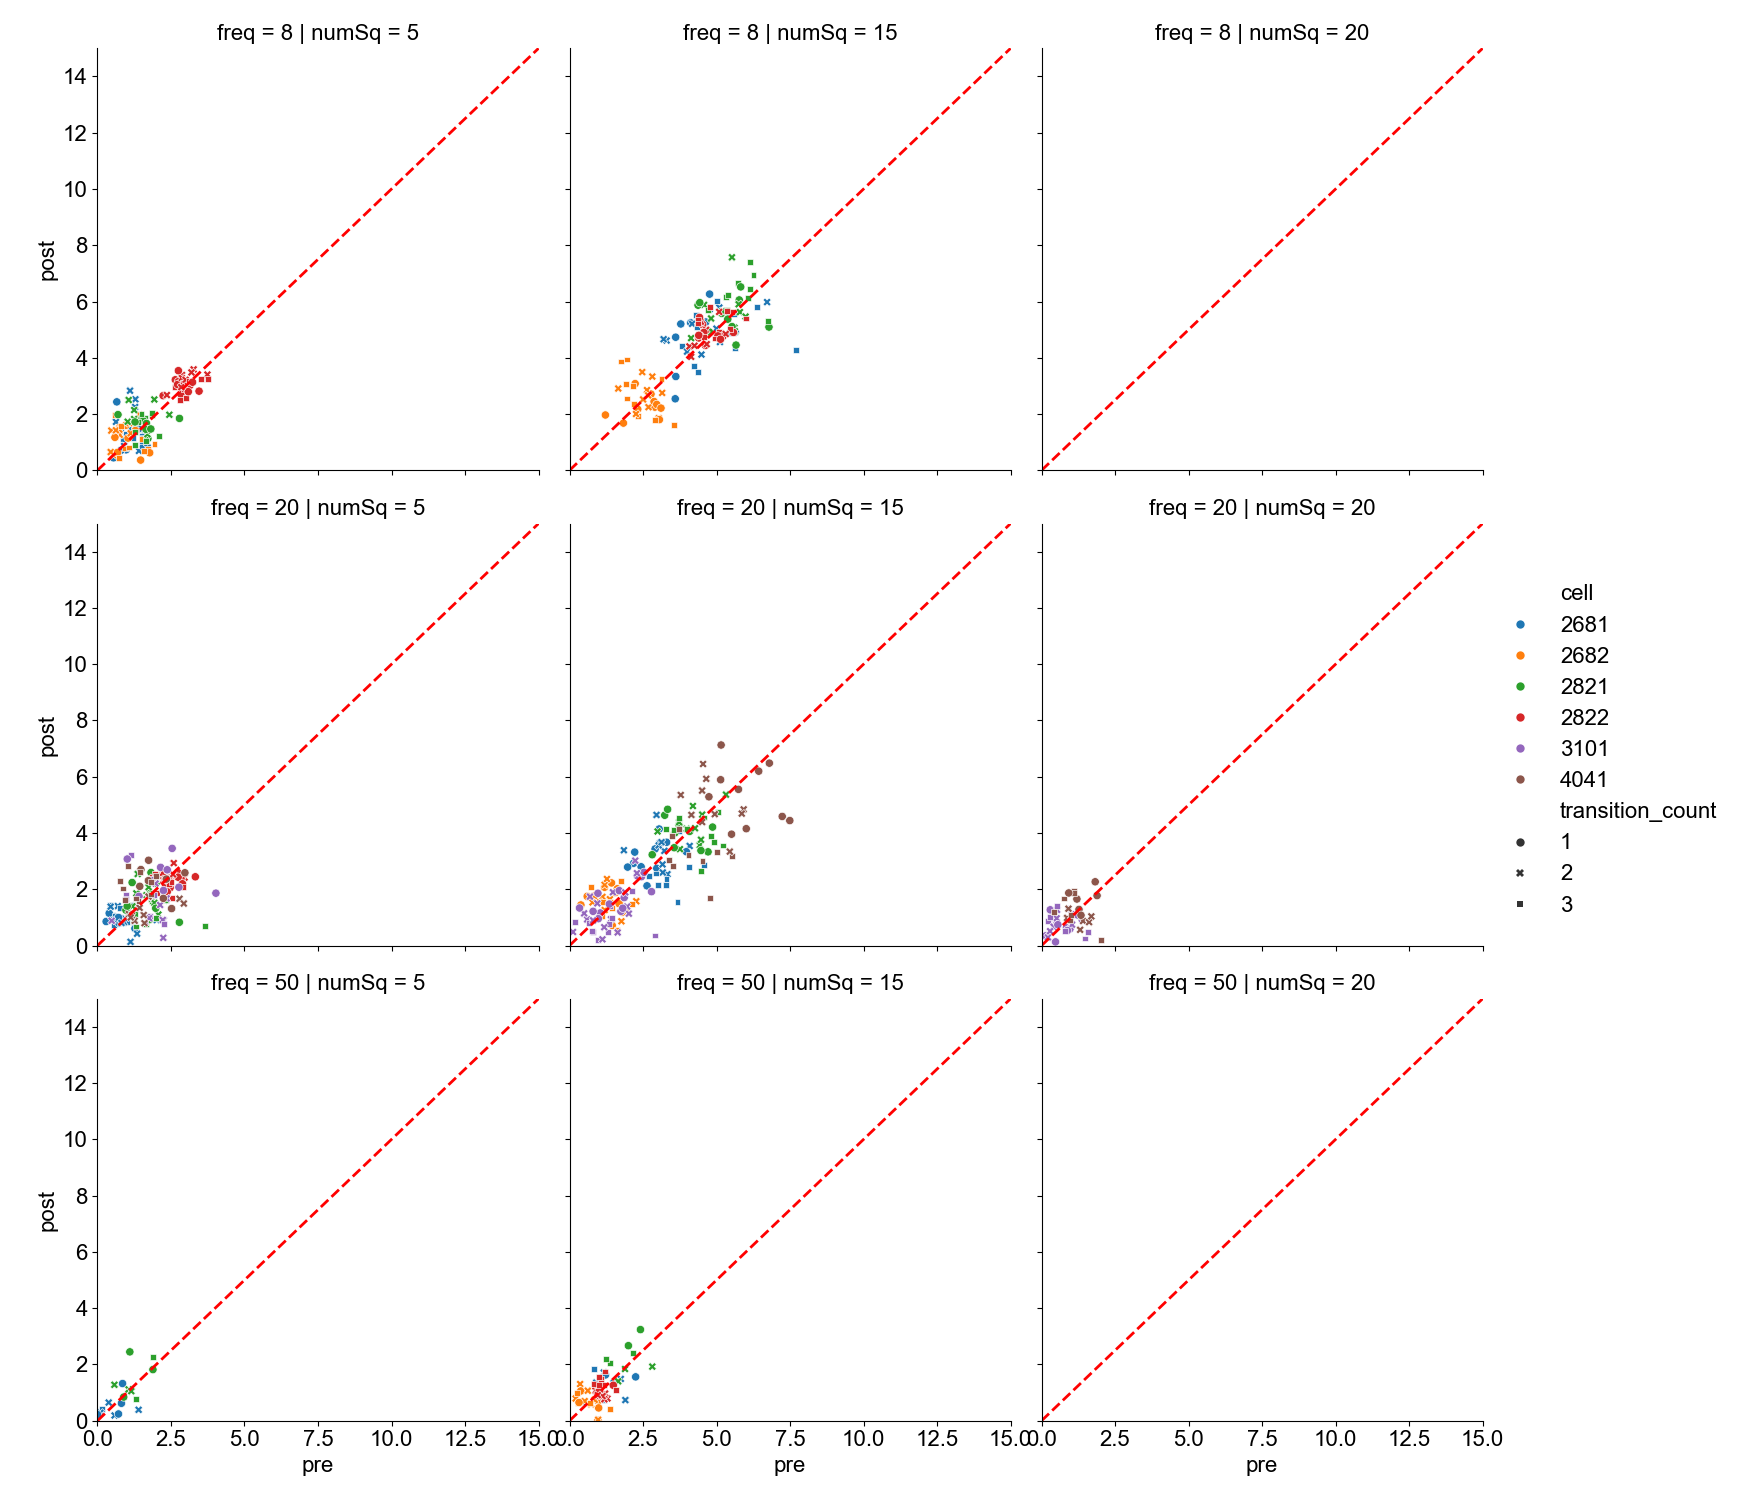

In [18]:
# plot pre vs post on a scatter plot
# a grid of histograms of post/pre ratio for each frequency and numSq
fg5 = sns.relplot(data=datadf_filt_wide, x='pre',y='post', row='freq', col='numSq', hue='cell', style='transition_count', palette='tab10')
# add a line at 1.0
for ax in fg5.axes.flat:
    ax.plot([0,15],[0,15], color='red', linestyle='--')
# # xlim
fg5.set(xlim=(0, 15))
fg5.set(ylim=(0, 15))


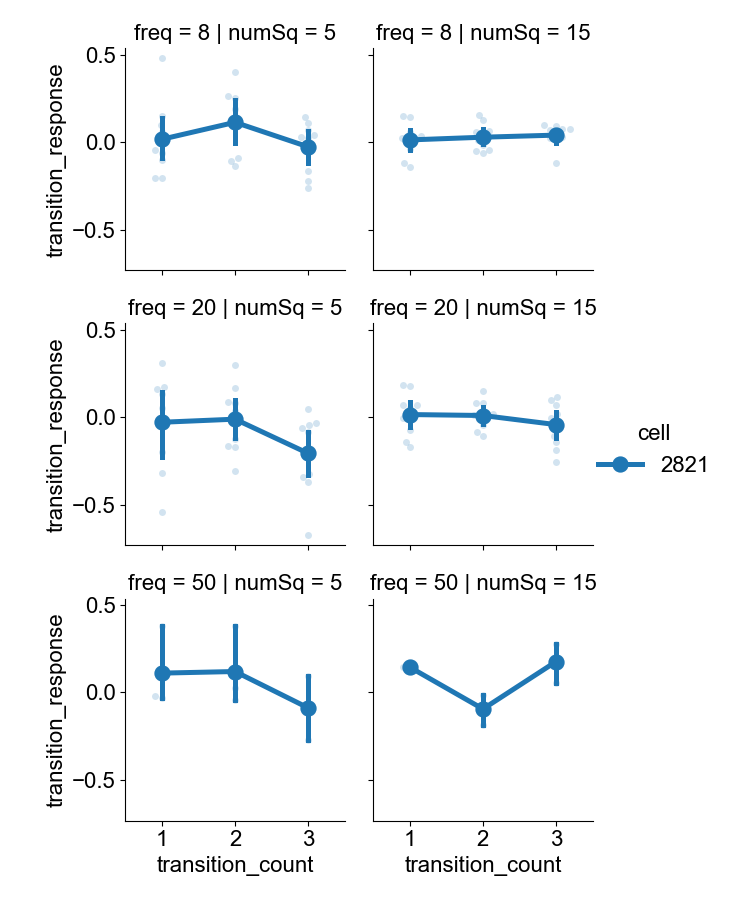

In [102]:
# plot transition response across numsq and frequency and cell
fg6 = sns.FacetGrid(datadf_filt_wide[datadf_filt_wide['cell']==2821], row='freq', col='numSq', hue='cell', palette='tab10',sharex=True, sharey=True,legend_out=True)
fg6.map(sns.swarmplot, 'transition_count', 'transition_response', order=[1,2,3] , dodge=True, alpha=0.2)
fg6.map(sns.pointplot, 'transition_count', 'transition_response', order=[1,2,3] , dodge=True)
# legend
fg6.add_legend()

## Comparison

In [7]:
import surprise_w2 as sur
import plotFig8_v20 as p8
import importlib
importlib.reload(sur)

<module 'surprise_w2' from 'c:\\Users\\Aditya\\OneDrive\\NCBS\\Lab\\Projects\\EI_Dynamics\\Analysis\\surprise_w2.py'>

In [8]:
rawdatadf.head(3)

cellID sex ageAtInj ageAtExpt incubation unit location  protocol  exptSeq  \
0    4041   F  31 days  101 days    70 days   mV      CA1  surprise        4   
1    4041   F  31 days  101 days    70 days   mV      CA1  surprise        4   
2    4041   F  31 days  101 days    70 days   mV      CA1  surprise        4   

   exptID  ...  ch0_response  baseline_noise_stddev stim_noise_stddev  \
0       9  ...           1.0                  0.118             0.492   
1       9  ...           1.0                  0.121             0.932   
2       9  ...           1.0                  0.133             1.623   

   spike_in_baseline_period  spike_in_stim_period ch0_drift  \
0                       0.0                   0.0       0.0   
1                       0.0                   0.0       0.0   
2                       0.0                   0.0       0.0   

  ac_noise_power_in_ch0 ch3_response  ch3_drift  ac_noise_power_in_ch3  
0                  17.0          1.0        0.0                   47.0  
1                   9.0          1.0        0.0                   40.0  
2                   8.0          1.0        0.0                   34.0  

[3 rows x 400059 columns]

In [9]:
datadf_upi = p8.obtainTransitions(rawdatadf)

1, cell4041, freq20, sweep1, seq6, bad
2, cell4041, freq20, sweep2, seq6, bad
3, cell4041, freq20, sweep3, seq6, bad
4, cell4041, freq20, sweep4, seq6, bad
5, cell4041, freq20, sweep5, seq6, bad
6, cell4041, freq20, sweep6, seq6, bad
7, cell4041, freq20, sweep7, seq6, bad
8, cell4041, freq20, sweep8, seq6, bad
9, cell4041, freq20, sweep9, seq6, bad
10, cell4041, freq20, sweep10, seq6, bad


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [162]:
for n in [5,15]:
    sample = rawdatadf[(rawdatadf['numSq']==n)]
    for cc in sample['cellID'].unique():
        cell_sample = sample[sample['cellID']==cc]
        pk, freq = sur.scanData(cell_sample)
        for idx, ff in enumerate(sorted(freq)):
            print( "Plotting: ", n, cc, ff, flush = True )
            sur.ttestPks( np.array(freq[ff]), 'less', ff, idx )

Plotting:  5 4041 20
Transition-wise pvals: 0.1471, 0.9734, 0.0007
Plotting:  5 3101 20
Transition-wise pvals: 0.3108, 0.9852, 0.2262


KeyboardInterrupt: 

## Wilcoxon test results on detected transitions (alt='less')

In [ ]:
Plotting:  5 4041 20
Transition-wise pvals: 0.1471, 0.9734, 0.0007
Plotting:  5 3101 20
Transition-wise pvals: 0.3108, 0.9852, 0.2262
Plotting:  5 2822 20
Transition-wise pvals: 0.8988, 0.0527, 0.8847
Plotting:  5 2681 20
Transition-wise pvals: 0.2375, 0.7271, 0.0570
Plotting:  5 2821 20
Transition-wise pvals: 0.1955, 0.4516, 0.8662

Plotting:  5 2681 8
Transition-wise pvals: 0.2152, 0.0570, 0.7271
Plotting:  5 2682 8
Transition-wise pvals: 0.1153, 0.0028, 0.6219
Plotting:  5 2821 8
Transition-wise pvals: 0.8154, 0.2613, 0.4661
Plotting:  5 2822 8
Transition-wise pvals: 0.2979, 0.1012, 0.7955

Plotting:  5 2681 50
Transition-wise pvals: 0.9430, 0.5364, 0.9053
Plotting:  5 2821 50
Transition-wise pvals: 0.7017, 0.2166, 0.9477




Plotting:  15 2681 8
Transition-wise pvals: 0.1305, 0.2375, 0.5073
Plotting:  15 2682 8
Transition-wise pvals: 0.8847, 0.3371, 0.2375
Plotting:  15 2822 8
Transition-wise pvals: 0.5555, 0.4288, 0.0274
Plotting:  15 2821 8
Transition-wise pvals: 0.2179, 0.0060, 0.3089

Plotting:  15 2821 20
Transition-wise pvals: 0.0338, 0.6963, 0.2758
Plotting:  15 2822 20
Transition-wise pvals: 0.0087, 0.0333, 0.5162
Plotting:  15 4041 20
Transition-wise pvals: 0.9800, 0.7510, 0.9998
ERROR: wrong number of pulses 32 detected
Plotting:  15 3101 20
Transition-wise pvals: 0.0557, 0.4600, 0.9852
Plotting:  15 2681 20
Transition-wise pvals: 0.0077, 0.1387, 0.9958
Plotting:  15 2682 20
Transition-wise pvals: 0.0014, 0.5508, 0.5653

Plotting:  15 2681 50
Transition-wise pvals: 0.9385, 0.4062, 0.7147
Plotting:  15 2682 50
Transition-wise pvals: 0.8376, 0.0020, 0.8154
Plotting:  15 2821 50
Transition-wise pvals: 0.8373, 0.9210, 0.0000
ERROR: wrong number of pulses 34 detected
ERROR: wrong number of pulses 32 detected
Plotting:  15 2822 50
Transition-wise pvals: 1.0000, 0.2979, 0.0000

In [128]:
# statistically significant transitions (old, wilcoxon 2 sided)
numcells_detecting_any_transition = [
    [8,5,0/12,0/4],
    [8,15,2/12,2/4],
    [20,5,3/12,3/4],
    [20,15,4/15,2/5],
    [50,5,2/6,2/2],
    [50,15,6/12,3/4],
]

# statistically significant transitions (old, wilcoxon alt=less)
# numcells_detecting_any_transition = [
#     [8,5,1/12,1/4],
#     [8,15,2/12,2/4],
#     [20,5,1/15,1/5],
#     [20,15,5/18,4/6],
#     [50,5,0/6,0/2],
#     [50,15,3/12,3/4],
# ]

In [129]:
numcells_detecting_any_transition_df = pd.DataFrame(numcells_detecting_any_transition, columns=['freq', 'numSq', 'total_transitions_detected', 'numcells_detecting_any_transition'])

<Axes: xlabel='freq', ylabel='numSq'>

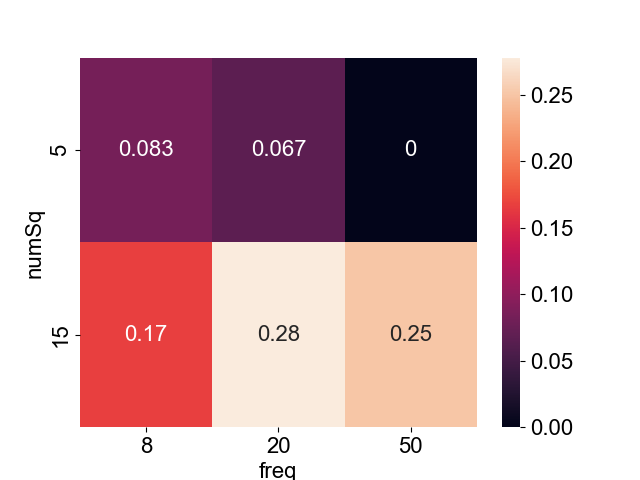

In [123]:
# make a heatmap of numcells_detecting_any_transition_df
fig, ax = plt.subplots(1,1, )
sns.heatmap(numcells_detecting_any_transition_df.pivot_table(index='numSq', columns='freq', values='total_transitions_detected'), annot=True, ax=ax)

<Axes: xlabel='freq', ylabel='numSq'>

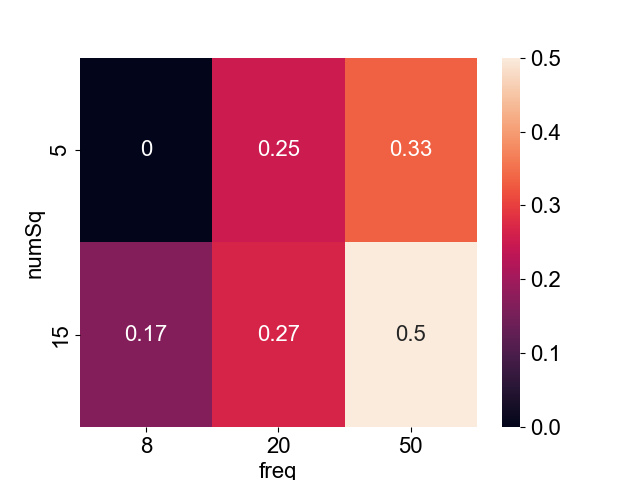

In [130]:
# make a heatmap of numcells_detecting_any_transition_df
fig, ax = plt.subplots(1,1, )
sns.heatmap(numcells_detecting_any_transition_df.pivot_table(index='numSq', columns='freq', values='total_transitions_detected'), annot=True, ax=ax)

In [132]:
datadf_filt_wide.head(5)

pulse  cell  expt  numSq  freq  repeat  transition_count        -2        -1  \
0      2681     1     15     8       1                 1  6.022677  3.250291   
1      2681     1     15     8       1                 2  3.881421  5.092398   
2      2681     1     15     8       1                 3  2.853698  4.786455   
3      2681     1     15     8       2                 1  3.907132  3.283493   
4      2681     1     15     8       2                 2  4.135740  3.857745   

pulse         0         1  transition_response       pre      post  
0      4.898289  5.645387             0.064123  4.636484  5.271838  
1      3.079868  5.149485            -0.043275  4.486909  4.114676  
2      4.634461  4.234388             0.074426  3.820076  4.434425  
3      3.010845  2.075357            -0.171414  3.595312  2.543101  
4      3.739316  4.701461             0.027217  3.996742  4.220388

In [154]:
# for each frequency, numSq combinations, make a data slice. in that data slice, for each cell, for each transition_count make a wilcoxon test
# store the pvalues in a dataframe
from scipy.stats import wilcoxon
pvals = []
for f in datadf_filt_wide['freq'].unique():
    for n in datadf_filt_wide['numSq'].unique():
        sample = datadf_filt_wide[(datadf_filt_wide['freq']==f)&(datadf_filt_wide['numSq']==n)]
        for c in sample['cell'].unique():
            cell_sample = sample[sample['cell']==c]
            for t in [1,2,3]:
                print(f,n,c,t)
                transition_sample = cell_sample[cell_sample['transition_count']==t]
                pre = np.array([transition_sample[-2],transition_sample[-1]]).flatten()
                post = np.array([transition_sample[0],transition_sample[1]]).flatten()
                pvals.append({
                    'cell': c,
                    'freq': f,
                    'numSq': n,
                    'transition_count': t,
                    'pval': wilcoxon(pre, post, alternative='two-sided').pvalue
                })

In [155]:
pvals_df = pd.DataFrame(pvals, columns=['cell', 'freq', 'numSq', 'transition_count', 'pval'])

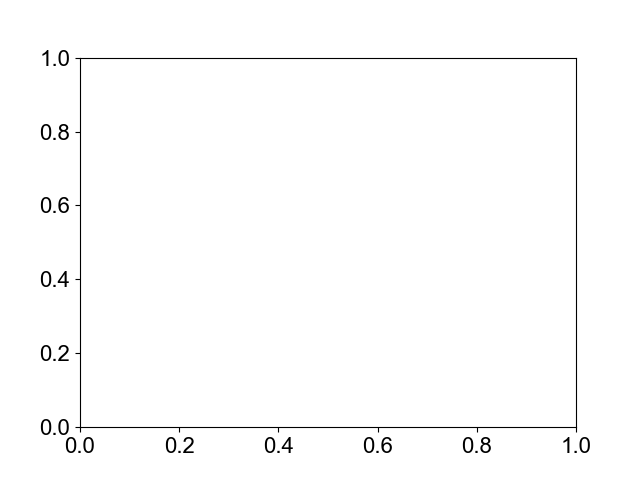

In [158]:
# for each freq, numsq combination, plot the fraction of transitions for which the pvalue is less than 0.05
fig, ax = plt.subplots(1,1)

pvals_df['significant'] = pvals_df['pval'] < 0.05
pvals_df['significant'] = pvals_df['significant'].astype(int)

# count the number of significant transitions for each cell, freq, numsq combination
fraction_significant_transitions = pvals_df.groupby(['numSq', 'freq'])['significant'].sum().reset_index()

In [159]:
fraction_significant_transitions

numSq  freq  significant
0      5     8            1
1      5    20            4
2      5    50            0
3     15     8            0
4     15    20            0
5     15    50            0
6     20    20            0

In [161]:
pvals_df.head(50)

cell  freq  numSq  transition_count      pval  significant
0   2681     8     15                 1  0.202450            0
1   2681     8     15                 2  0.123093            0
2   2681     8     15                 3  0.784126            0
3   2682     8     15                 1  0.261099            0
4   2682     8     15                 2  0.898317            0
5   2682     8     15                 3  0.368277            0
6   2821     8     15                 1  0.595819            0
7   2821     8     15                 2  0.311794            0
8   2821     8     15                 3  0.132727            0
9   2822     8     15                 1  0.701181            0
10  2822     8     15                 2  0.097307            0
11  2822     8     15                 3  0.230513            0
12  2681     8      5                 1  0.311794            0
13  2681     8      5                 2  0.430433            0
14  2681     8      5                 3  0.621513            0
15  2682     8      5                 1       NaN            0
16  2682     8      5                 2  0.017181            1
17  2682     8      5                 3  0.521673            0
18  2821     8      5                 1  0.898317            0
19  2821     8      5                 2       NaN            0
20  2821     8      5                 3       NaN            0
21  2822     8      5                 1  0.348810            0
22  2822     8      5                 2  0.075851            0
23  2822     8      5                 3  0.430433            0
24  2681    20     15                 1  0.132727            0
25  2681    20     15                 2  0.521673            0
26  2681    20     15                 3  0.053169            0
27  2682    20     15                 1  0.202450            0
28  2682    20     15                 2  0.329983            0
29  2682    20     15                 3       NaN            0
30  2821    20     15                 1  0.927279            0
31  2821    20     15                 2  0.956329            0
32  2821    20     15                 3  0.701181            0
33  3101    20     15                 1       NaN            0
34  3101    20     15                 2       NaN            0
35  3101    20     15                 3       NaN            0
36  4041    20     15                 1  0.261099            0
37  4041    20     15                 2  0.595819            0
38  4041    20     15                 3       NaN            0
39  2681    20      5                 1       NaN            0
40  2681    20      5                 2  0.927279            0
41  2681    20      5                 3  0.474905            0
42  2821    20      5                 1       NaN            0
43  2821    20      5                 2       NaN            0
44  2821    20      5                 3  0.007296            1
45  2822    20      5                 1  0.008308            1
46  2822    20      5                 2  0.674223            0
47  2822    20      5                 3  0.621513            0
48  3101    20      5                 1       NaN            0
49  3101    20      5                 2       NaN            0

In [168]:
rawdatapath = Path(r"C:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Surprise\all_cells_surprise_CC_long.h5")
rawdatadf = pd.read_hdf(rawdatapath, key='data')

pvals = []
for n in [5,15]:
    sample = rawdatadf[(rawdatadf['numSq']==n)]
    for cc in sample['cellID'].unique():
        cell_sample = sample[sample['cellID']==cc]
        pk, freq = sur.scanData(cell_sample)
        for ff in (sorted(freq)):
            for t in [1,2,3]:
                preidx, postidx = 8*(t-1)+7, 8*(t-1)+9
                pre  = np.array(freq[ff])[:, preidx : preidx+2 ].flatten()
                post = np.array(freq[ff])[:, postidx: postidx+2].flatten()
                pval = wilcoxon(pre, post, alternative='less').pvalue
                pvals.append({
                            'cell': cc,
                            'freq': ff,
                            'numSq':n,
                            'transition':t,
                            'pval':pval
                            })

ERROR: wrong number of pulses 32 detected
ERROR: wrong number of pulses 34 detected
ERROR: wrong number of pulses 32 detected


In [171]:
pvals_df = pd.DataFrame(pvals)
pvals_df['significant'] = pvals_df['pval'] < 0.05
pvals_df['significant'] = pvals_df['significant'].astype(int)

fraction_significant_transitions = pvals_df.groupby(['numSq', 'freq'])['significant'].mean().reset_index()

In [172]:
fraction_significant_transitions

numSq  freq  significant
0      5     8     0.083333
1      5    20     0.066667
2      5    50     0.000000
3     15     8     0.166667
4     15    20     0.277778
5     15    50     0.250000

In [174]:
pivotdf

freq         8         20    50
numSq                          
5      0.083333  0.066667  0.00
15     0.166667  0.277778  0.25